# Phase 1: Data Preprocessing and Feature Engineering

### CONVERT DOCX TO TABLE

In [15]:
import os
from docx import Document
import json
import pandas as pd

folder_path = "Train"
dataframes = []
for filename in os.listdir(folder_path):
    
    if filename.endswith(".docx") and not filename.startswith("~$"):
        file_path = os.path.join(folder_path, filename)
        try:
            doc = Document(file_path)
            
            json_text = ""
            for para in doc.paragraphs:
                json_text += para.text
                
            json_data = json.loads(json_text)

            df = pd.json_normalize(json_data)
            dataframes.append(df)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

if dataframes:
    final_dataframe = pd.concat(dataframes, ignore_index=True)
    print(final_dataframe.head())
    
    final_dataframe.to_csv("train.csv", index=False)
else:
    print("No valid .docx files found or processed.")


        type  status departure.iataCode departure.icaoCode departure.terminal  \
0  departure  active                lhe               opla                  m   
1  departure  active                lhe               opla                NaN   
2  departure  active                lhe               opla                NaN   
3  departure  active                lhe               opla                  m   
4  departure  active                lhe               opla                  m   

   departure.scheduledTime  departure.estimatedTime     departure.actualTime  \
0  2023-07-20t20:50:00.000  2023-07-20t20:00:00.000  2023-07-20t20:15:00.000   
1  2023-07-18t15:05:00.000  2023-07-18t15:05:00.000                      NaN   
2  2023-07-23t09:50:00.000                      NaN                      NaN   
3  2023-07-26t23:30:00.000  2023-07-26t23:30:00.000  2023-07-26t23:51:00.000   
4  2023-07-20t11:35:00.000  2023-07-20t17:15:00.000                      NaN   

  departure.estimatedRunway   de

In [16]:
import os
from docx import Document
import json
import pandas as pd

folder_path = "Test"
dataframes = []
for filename in os.listdir(folder_path):
    
    if filename.endswith(".docx") and not filename.startswith("~$"):
        file_path = os.path.join(folder_path, filename)
        try:
            doc = Document(file_path)
            
            json_text = ""
            for para in doc.paragraphs:
                json_text += para.text
                
            json_data = json.loads(json_text)

            df = pd.json_normalize(json_data)
            dataframes.append(df)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

if dataframes:
    final_dataframe = pd.concat(dataframes, ignore_index=True)
    print(final_dataframe.head())
    
    final_dataframe.to_csv("test.csv", index=False)
else:
    print("No valid .docx files found or processed.")


        type   status departure.iataCode departure.icaoCode  \
0  departure   active                lhe               opla   
1  departure   active                lhe               opla   
2  departure   active                lhe               opla   
3  departure  unknown                lhe               opla   
4  departure   active                lhe               opla   

   departure.scheduledTime departure.estimatedRunway   departure.actualRunway  \
0  2023-07-17t20:35:00.000   2023-07-17t20:46:00.000  2023-07-17t20:46:00.000   
1  2023-07-27t08:00:00.000                       NaN                      NaN   
2  2023-07-27t08:00:00.000                       NaN                      NaN   
3  2023-07-28t16:45:00.000                       NaN                      NaN   
4  2023-07-19t04:15:00.000   2023-07-19t04:18:00.000  2023-07-19t04:18:00.000   

  arrival.iataCode arrival.icaoCode    arrival.scheduledTime  ...  \
0              khi             opkc  2023-07-17t22:20:00.000  ...

### Preprocess weather data

In [53]:
#convert weather data into a conbined structured csv
def process_weather_file(file_path, month, year):
    sheet1_data = pd.read_excel(file_path, sheet_name='Sheet1')

    def restructure_data(column, prefix):
        cleaned_values = [
            re.sub(r'\b(Max|Avg|Min)\b', '', str(value)).strip()
            for value in sheet1_data[column].dropna()
        ]
        
        cleaned_values = " ".join(cleaned_values).split()
        
        max_values = cleaned_values[0::3]
        avg_values = cleaned_values[1::3]
        min_values = cleaned_values[2::3]
        
        return {
            f"{prefix} Max": max_values,
            f"{prefix} Avg": avg_values,
            f"{prefix} Min": min_values,
        }

    restructured_data = {}

    columns_to_restructure = {
        "Temperature (°F)": "Temp",
        "Dew Point (°F)": "Dew Point",
        "Humidity (%)": "Humidity",
        "Wind Speed (mph)": "Wind Speed",
        "Pressure (in)": "Pressure",
    }

    for column, prefix in columns_to_restructure.items():
        column_data = restructure_data(column, prefix)
        restructured_data.update(column_data)

    if "Precipitation (in)" in sheet1_data.columns:
        precipitation_values = sheet1_data["Precipitation (in)"].dropna()
        precipitation_cleaned = [
            re.sub(r'\b(Max|Avg|Min|Total)\b', '', str(value)).strip()
            for value in precipitation_values
        ]
        precipitation_cleaned = " ".join(precipitation_cleaned).split()
        restructured_data["Precipitation (in) Total"] = precipitation_cleaned

    if "Time" in sheet1_data.columns:
        time_values = sheet1_data["Time"].dropna()
        
        time_values = time_values.str.split()  
        days = time_values.iloc[0][1:]
        
        dates_cleaned = []
        for day in days:
            try:
                date = datetime.strptime(f"{year} {month} {day}", "%Y %m %d")
                dates_cleaned.append(date.strftime("%Y-%m-%d"))
            except ValueError:
                print(f"Skipping invalid day: {day} for month {month}, year {year}")
        
        total_days_in_month = (datetime(year, month % 12 + 1, 1) - datetime(year, month, 1)).days
        dates_cleaned = dates_cleaned[:total_days_in_month]

        restructured_data["Date"] = dates_cleaned

    max_length = max(len(values) for values in restructured_data.values())
    for key in restructured_data:
        restructured_data[key] += [None] * (max_length - len(restructured_data[key]))

    cleaned_data = pd.DataFrame(restructured_data)

    columns_order = ["Date"] + [col for col in cleaned_data.columns if col != "Date"]
    cleaned_data = cleaned_data[columns_order]

    return cleaned_data

weather_directory = "Weather"  
all_weather_data = pd.DataFrame()

start_month = 7  
start_year = 2023

total_files = 13

for i in range(total_files):
    file_path = f"{weather_directory}/{i+1}.xlsx" 

    if i < 6:  
        current_month = (start_month + i - 1) % 12 + 1
        current_year = start_year + (start_month + i - 1) // 12
    else:  
        current_month = (start_month + i - 1) % 12 + 1
        current_year = 2024

    print(f"Processing file: {file_path}, Month: {current_month}, Year: {current_year}")

    processed_data = process_weather_file(file_path, current_month, current_year)
    all_weather_data = pd.concat([all_weather_data, processed_data], ignore_index=True)

all_weather_data.to_excel("weather.xlsx", index=False)

Processing file: Weather/1.xlsx, Month: 7, Year: 2023
Processing file: Weather/2.xlsx, Month: 8, Year: 2023
Processing file: Weather/3.xlsx, Month: 9, Year: 2023
Processing file: Weather/4.xlsx, Month: 10, Year: 2023
Processing file: Weather/5.xlsx, Month: 11, Year: 2023
Processing file: Weather/6.xlsx, Month: 12, Year: 2023
Processing file: Weather/7.xlsx, Month: 1, Year: 2024
Processing file: Weather/8.xlsx, Month: 2, Year: 2024
Processing file: Weather/9.xlsx, Month: 3, Year: 2024
Processing file: Weather/10.xlsx, Month: 4, Year: 2024
Processing file: Weather/11.xlsx, Month: 5, Year: 2024
Processing file: Weather/12.xlsx, Month: 6, Year: 2024
Processing file: Weather/13.xlsx, Month: 7, Year: 2024


### Preprocess Test data

In [6]:
file_path = 'test.csv'
test_data = pd.read_csv(file_path)

date_columns = [
    "departure.scheduledTime",
    "departure.estimatedRunway",
    "departure.actualRunway",
    "arrival.scheduledTime",
    "arrival.estimatedTime",
    "arrival.actualTime",
    "arrival.estimatedRunway",
    "arrival.actualRunway"
]

for col in date_columns:
    if col in test_data.columns:
        test_data[col] = pd.to_datetime(test_data[col], errors='coerce')

test_data.to_csv('processed_test.csv', index=False)


### Integrate test and Weather

In [40]:
from datetime import datetime

test_data = pd.read_csv('test.csv')
weather_data = pd.read_excel('weather.xlsx')

test_data["departure.scheduledTime"] = pd.to_datetime(test_data["departure.scheduledTime"])
weather_data["Date"] = pd.to_datetime(weather_data["Date"]).dt.date  
test_data["Date"] = test_data["departure.scheduledTime"].dt.date 

merged_data = pd.merge(
    test_data,
    weather_data,
    on="Date",
    how="left"
)

time_fields = [
    "departure.scheduledTime", "departure.actualRunway", 
    "arrival.scheduledTime", "arrival.estimatedTime", 
    "arrival.actualTime", "arrival.estimatedRunway", "arrival.actualRunway"
]

for field in time_fields:
    if field in merged_data.columns:
        merged_data[field] = pd.to_datetime(merged_data[field], errors="coerce")

merged_data["departure.delay"] = (merged_data["departure.actualRunway"] - merged_data["departure.scheduledTime"]).dt.total_seconds() / 60

merged_data["departure.delay"] = merged_data["departure.delay"].clip(lower=0)

columns_to_check = [
    "flight.number", "type", "status", "departure.iataCode", "departure.icaoCode",
    "departure.scheduledTime", "arrival.iataCode", "arrival.icaoCode", "arrival.estimatedTime", "departure.delay"
]
merged_data = merged_data.dropna(subset=columns_to_check)

weather_features = ["Temp Avg", "Wind Speed Avg", "Humidity Avg", "Pressure Avg", "Precipitation (in) Total"]
merged_data = merged_data[[ 
    "flight.number","type","status","departure.iataCode","departure.icaoCode", 
    "departure.scheduledTime","arrival.iataCode","arrival.icaoCode","arrival.estimatedTime", 
    "departure.delay","departure.actualRunway", "Date"
] + [feature for feature in weather_features if feature in merged_data.columns]]

merged_data["day_of_week"] = merged_data["departure.scheduledTime"].dt.day_name()
merged_data["hour_of_day"] = merged_data["departure.scheduledTime"].dt.hour
merged_data["month_of_year"] = merged_data["departure.scheduledTime"].dt.month
merged_data["year"] = merged_data["departure.scheduledTime"].dt.year

print("Processed Data Sample:")
print(merged_data.head())

merged_data.to_csv("processed_test.csv", index=False)


Processed Data Sample:
    flight.number       type  status departure.iataCode departure.icaoCode  \
0             847  departure  active                lhe               opla   
4            3932  departure  active                lhe               opla   
13            629  departure  active                lhe               opla   
14            410  departure  active                lhe               opla   
23            707  departure  active                lhe               opla   

   departure.scheduledTime arrival.iataCode arrival.icaoCode  \
0      2023-07-17 20:35:00              khi             opkc   
4      2023-07-19 04:15:00              auh             omaa   
13     2023-07-28 09:55:00              doh             othh   
14     2023-07-30 14:45:00              dxb             omdb   
23     2023-07-26 04:25:00              ist             ltfm   

   arrival.estimatedTime  departure.delay  ...        Date Temp Avg  \
0    2023-07-17 22:12:00             11.0  ...  2023

### Integrte weather and train data

In [80]:
from datetime import datetime
import pandas as pd

train_data = pd.read_csv('train.csv')
weather_data = pd.read_excel('weather.xlsx')

#integratedata
train_data["departure.scheduledTime"] = pd.to_datetime(train_data["departure.scheduledTime"])
weather_data["Date"] = pd.to_datetime(weather_data["Date"]).dt.date  # Keep only the date part
train_data["Date"] = train_data["departure.scheduledTime"].dt.date  # Ensure this is also just the date part

# Merge both datas
merged_data = pd.merge(
    train_data,
    weather_data,
    on="Date",
    how="left"
)

#remove nan
#numerical with mean
numerical_columns = merged_data.select_dtypes(include=['number']).columns
merged_data[numerical_columns] = merged_data[numerical_columns].fillna(merged_data[numerical_columns].mean())

#categoricalwith mode
categorical_columns = merged_data.select_dtypes(include=['object']).columns
merged_data[categorical_columns] = merged_data[categorical_columns].fillna(merged_data[categorical_columns].mode().iloc[0])

#correct time format
time_fields = [
    "departure.scheduledTime", "departure.actualTime", "departure.estimatedTime",
    "arrival.scheduledTime", "arrival.actualTime", "arrival.estimatedTime"
]

for field in time_fields:
    if field in merged_data.columns:
        merged_data[field] = pd.to_datetime(merged_data[field], errors="coerce")

#calculate delay
merged_data["departure.delay"] = (merged_data["departure.actualTime"] - merged_data["departure.scheduledTime"]).dt.total_seconds() / 60

# Replace negative delays with 0
merged_data["departure.delay"] = merged_data["departure.delay"].clip(lower=0)

#fill missing delay values
merged_data["departure.delay"] = merged_data["departure.delay"].fillna(0)

#merge relevant weather features
weather_features = ["Temp Avg", "Wind Speed Avg", "Humidity Avg", "Pressure Avg", "Precipitation (in) Total"]
merged_data = merged_data[[
    "status", "departure.scheduledTime", "departure.actualTime", "departure.estimatedTime",
    "arrival.scheduledTime", "arrival.actualTime", "departure.delay", "airline.name", "Date"
] + weather_features]

#day hour moth year
merged_data["day_of_week"] = merged_data["departure.scheduledTime"].dt.day_name()
merged_data["hour_of_day"] = merged_data["departure.scheduledTime"].dt.hour
merged_data["month_of_year"] = merged_data["departure.scheduledTime"].dt.month
merged_data["year"] = merged_data["departure.scheduledTime"].dt.year

print("Processed Data Sample:")
print(merged_data.head())

merged_data.to_csv("processed_train.csv", index=False)


Processed Data Sample:
   status departure.scheduledTime departure.actualTime  \
0  active     2023-07-20 20:50:00  2023-07-20 20:15:00   
1  active     2023-07-18 15:05:00  2023-11-07 09:19:00   
2  active     2023-07-23 09:50:00  2023-11-07 09:19:00   
3  active     2023-07-26 23:30:00  2023-07-26 23:51:00   
4  active     2023-07-20 11:35:00  2023-11-07 09:19:00   

  departure.estimatedTime arrival.scheduledTime  arrival.actualTime  \
0     2023-07-20 20:00:00   2023-07-20 23:20:00 2024-01-27 00:04:00   
1     2023-07-18 15:05:00   2023-07-18 16:50:00 2024-01-27 00:04:00   
2     2023-07-21 04:00:00   2023-07-23 11:35:00 2024-01-27 00:04:00   
3     2023-07-26 23:30:00   2023-07-27 01:30:00 2024-01-27 00:04:00   
4     2023-07-20 17:15:00   2023-07-20 14:00:00 2024-01-27 00:04:00   

   departure.delay                     airline.name        Date  Temp Avg  \
0              0.0                           saudia  2023-07-20      88.2   
1         160934.0                        flyji

# Phase 2: Exploratory Data Analysis (EDA)

###  Visualization

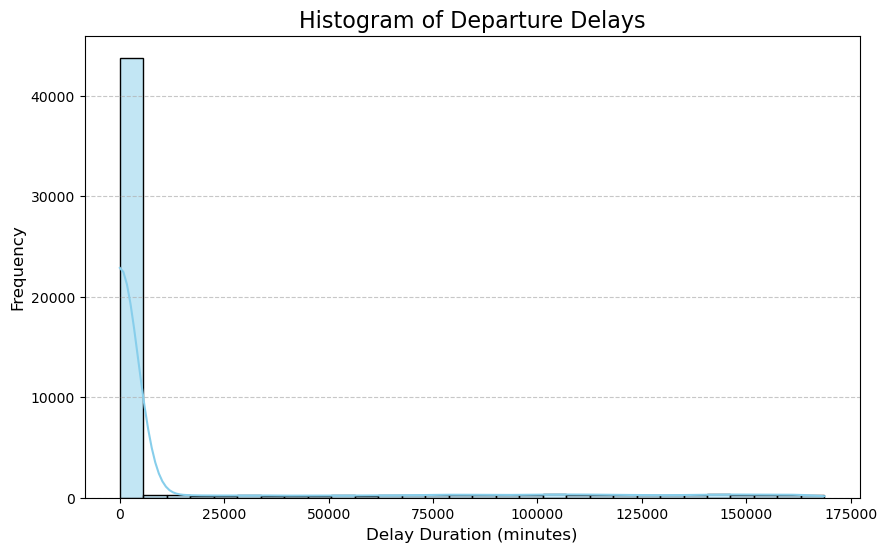

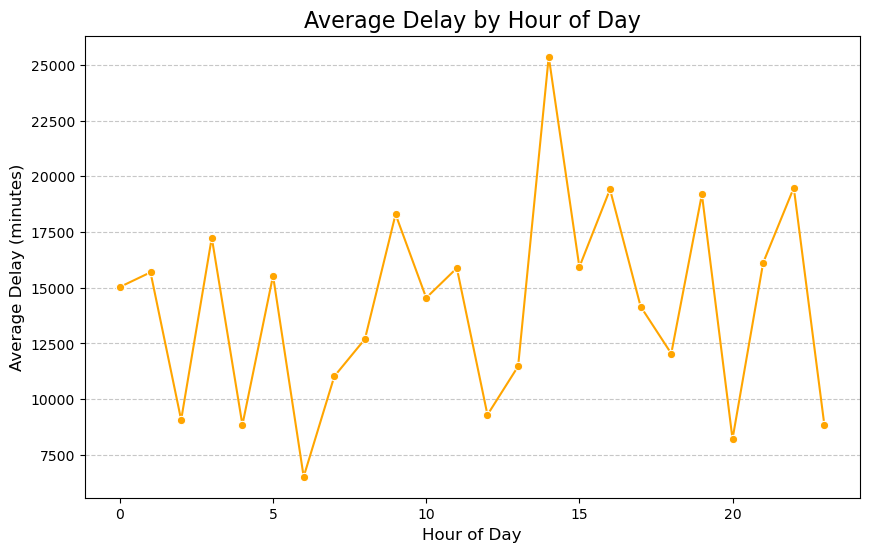

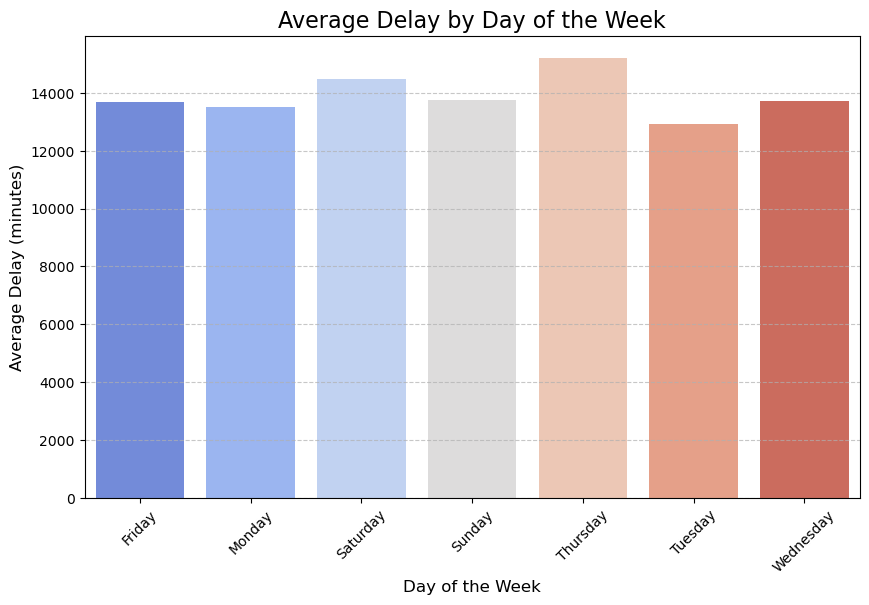

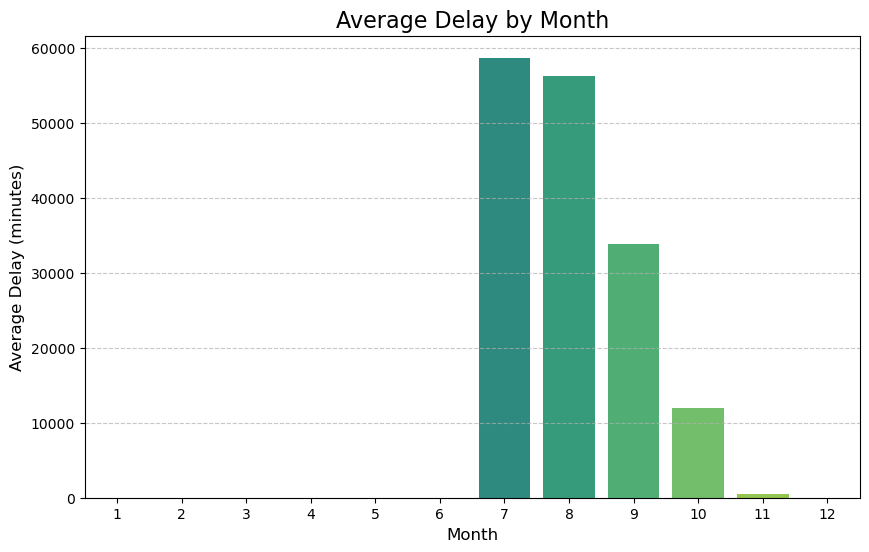

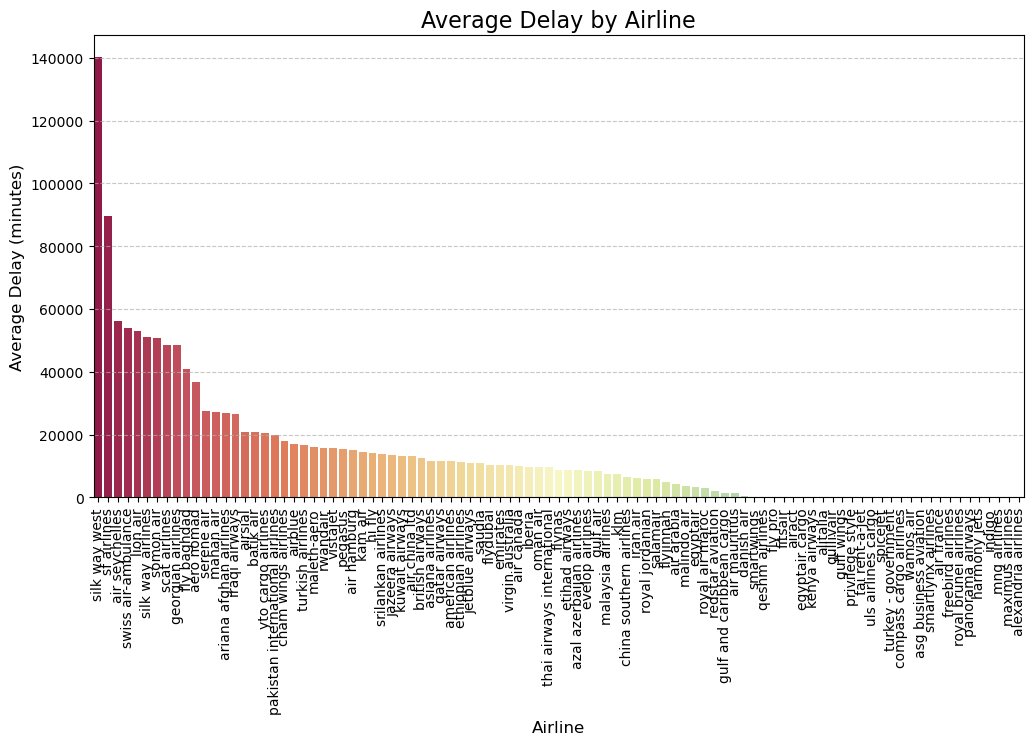

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

processed_data = pd.read_csv("processed_train.csv")

#Delay Distributions: Histogram of delay durations
plt.figure(figsize=(10, 6))
sns.histplot(data=processed_data, x="departure.delay", bins=30, kde=True, color="skyblue")
plt.title("Histogram of Departure Delays", fontsize=16)
plt.xlabel("Delay Duration (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Temporal Analysis: Line plots or bar charts for delays across hours, days, and months
# Average delay by hour
hourly_delay = processed_data.groupby("hour_of_day")["departure.delay"].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_delay.index, y=hourly_delay.values, marker="o", color="orange")
plt.title("Average Delay by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average delay by day of the week
day_delay = processed_data.groupby("day_of_week")["departure.delay"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=day_delay.index, y=day_delay.values, palette="coolwarm")
plt.title("Average Delay by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# Average delay by month
month_delay = processed_data.groupby("month_of_year")["departure.delay"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=month_delay.index, y=month_delay.values, palette="viridis")
plt.title("Average Delay by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Category-Wise Analysis: Group delays by airline, departure airport, or flight status
# Average delay by airline
airline_delay = processed_data.groupby("airline.name")["departure.delay"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_delay.index, y=airline_delay.values, palette="Spectral")
plt.title("Average Delay by Airline", fontsize=16)
plt.xlabel("Airline", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Correlation Analysis

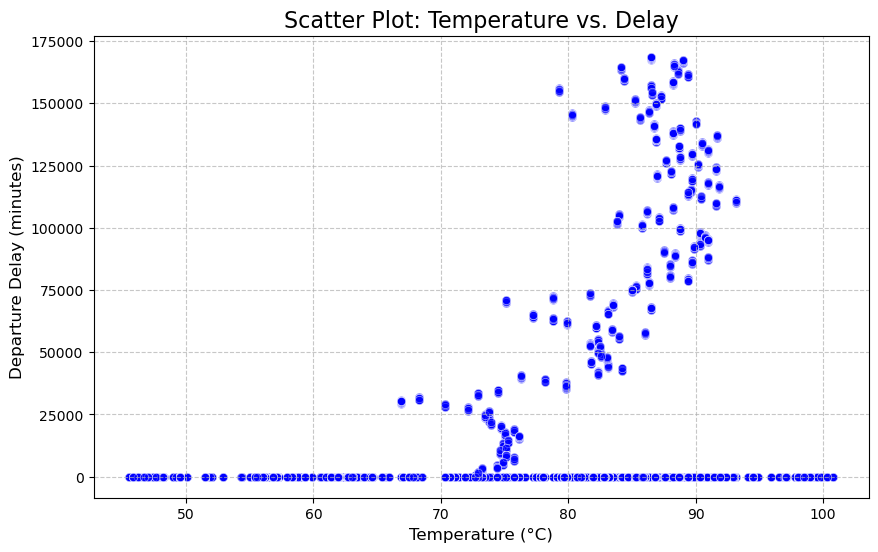

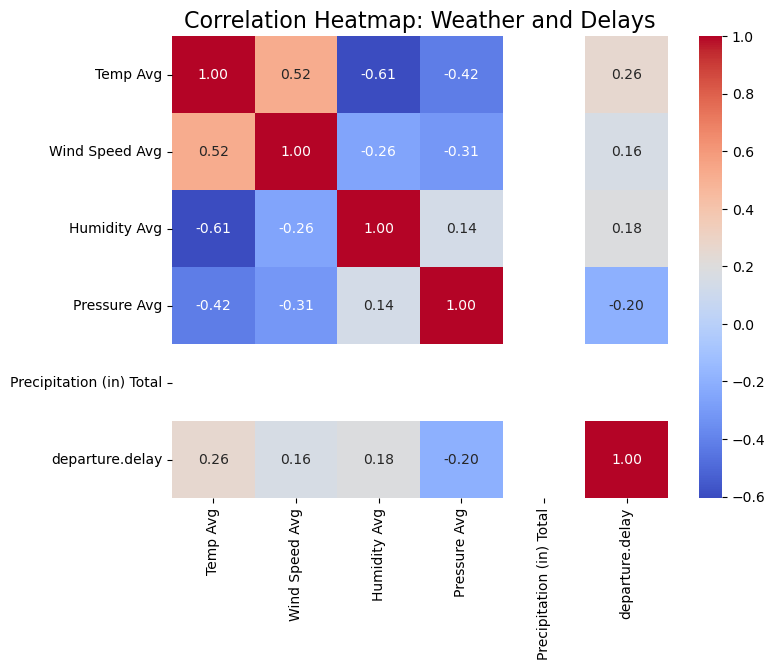

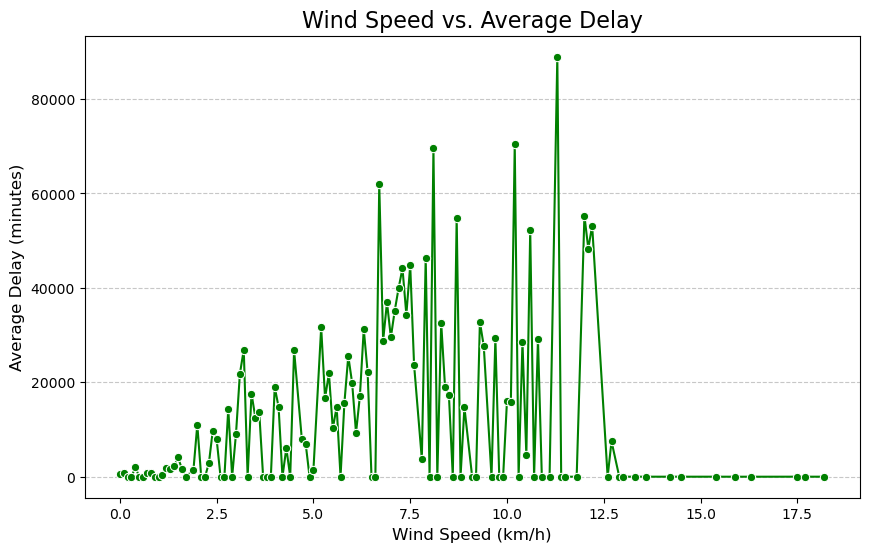

In [3]:
#The relationship between weather and flight data. (at least 3 different visualizations)
#scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=processed_data, x="Temp Avg", y="departure.delay", alpha=0.6, color="blue")
plt.title("Scatter Plot: Temperature vs. Delay", fontsize=16)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Departure Delay (minutes)", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Correlation heatmap
weather_features = ["Temp Avg", "Wind Speed Avg", "Humidity Avg", "Pressure Avg", "Precipitation (in) Total", "departure.delay"]
correlation_matrix = processed_data[weather_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Weather and Delays", fontsize=16)
plt.show()

#Line plot
wind_delay = processed_data.groupby("Wind Speed Avg")["departure.delay"].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=wind_delay.index, y=wind_delay.values, marker="o", color="green")
plt.title("Wind Speed vs. Average Delay", fontsize=16)
plt.xlabel("Wind Speed (km/h)", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Comparison

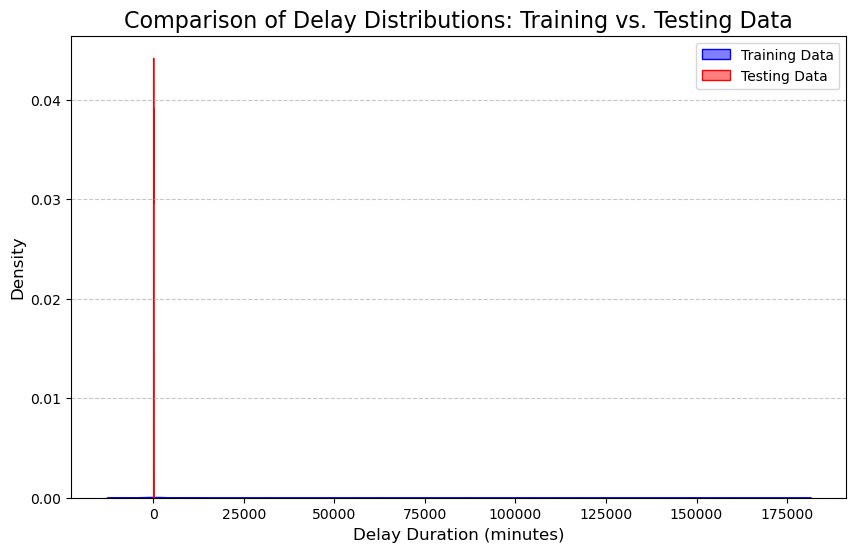

In [42]:
test_data = pd.read_csv("processed_test.csv")

plt.figure(figsize=(10, 6))
sns.kdeplot(data=processed_data, x="departure.delay", label="Training Data", fill=True, alpha=0.5, color="blue")
sns.kdeplot(data=test_data, x="departure.delay", label="Testing Data", fill=True, alpha=0.5, color="red")
plt.title("Comparison of Delay Distributions: Training vs. Testing Data", fontsize=16)
plt.xlabel("Delay Duration (minutes)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Phase 3: Analytical and Predictive Tasks

### Binary Classification

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

data = pd.read_csv('processed_train.csv')

data['delay_binary'] = (data['departure.delay'] > 0).astype(int)

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]
y = data['delay_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

binary_model = RandomForestClassifier(random_state=42)
binary_model.fit(X_train, y_train)

y_pred = binary_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['On-time', 'Delayed'])

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.7131362094037809
Precision: 0.7742254915829679
Recall: 0.8006143943826799
F1-Score: 0.7871988493347717
Confusion Matrix:
 [[1883 1596]
 [1363 5473]]
Classification Report:
               precision    recall  f1-score   support

     On-time       0.58      0.54      0.56      3479
     Delayed       0.77      0.80      0.79      6836

    accuracy                           0.71     10315
   macro avg       0.68      0.67      0.67     10315
weighted avg       0.71      0.71      0.71     10315



### Multi-Class Classification

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support

data = pd.read_csv('processed_train.csv')

def categorize_delay(delay):
    if delay == 0:
        return 'No Delay'
    elif delay < 45:
        return 'Short Delay'
    elif 45 <= delay <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

data['delay_category'] = data['departure.delay'].apply(categorize_delay)

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]
y = data['delay_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

multi_model = RandomForestClassifier(random_state=42)
multi_model.fit(X_train, y_train)

y_pred = multi_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
class_precision_recall_f1 = precision_recall_fscore_support(y_test, y_pred, labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'], zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'], zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

print("Class-wise Precision, Recall, F1-Score:")
for label, p, r, f in zip(['No Delay', 'Short Delay', 'Moderate Delay', 'Long Delay'], class_precision_recall_f1[0], class_precision_recall_f1[1], class_precision_recall_f1[2]):
    print(f"{label}: Precision={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")


Accuracy: 0.5796412990790112
Precision: 0.5774483180257615
Recall: 0.5796412990790112
F1-Score: 0.5782775522744322
Confusion Matrix:
 [[ 866    5   57  673]
 [  10    8   28   46]
 [ 105   13 1937 1424]
 [ 609   19 1347 3168]]
Classification Report:
                 precision    recall  f1-score   support

      No Delay       0.54      0.54      0.54      1601
   Short Delay       0.18      0.09      0.12        92
Moderate Delay       0.57      0.56      0.57      3479
    Long Delay       0.60      0.62      0.61      5143

      accuracy                           0.58     10315
     macro avg       0.47      0.45      0.46     10315
  weighted avg       0.58      0.58      0.58     10315

Class-wise Precision, Recall, F1-Score:
No Delay: Precision=0.57, Recall=0.56, F1-Score=0.57
Short Delay: Precision=0.60, Recall=0.62, F1-Score=0.61
Moderate Delay: Precision=0.18, Recall=0.09, F1-Score=0.12
Long Delay: Precision=0.54, Recall=0.54, F1-Score=0.54


### Regression model

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv('processed_train.csv')

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]
y = data['departure.delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)

y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Cross-Validated Mean Absolute Error (CV MAE):", cv_mae)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Square Error (RMSE):", rmse)


Cross-Validated Mean Absolute Error (CV MAE): 13468.437202160374
Mean Absolute Error (MAE): 13333.100025404077
Root Mean Square Error (RMSE): 30219.233083475236


# Phase 4: Model Optimization and Evaluation

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error, mean_squared_error

data = pd.read_csv('processed_train.csv')

def categorize_delay(delay):
    if delay == 0:
        return 'No Delay'
    elif delay < 45:
        return 'Short Delay'
    elif 45 <= delay <= 175:
        return 'Moderate Delay'
    else:
        return 'Long Delay'

data['delay_category'] = data['departure.delay'].apply(categorize_delay)

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]

binary_target = data['departure.delay'].apply(lambda x: 0 if x == 0 else 1)

multi_target = data['delay_category']

delay_duration_target = data['departure.delay']

X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, binary_target, test_size=0.2, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, multi_target, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, delay_duration_target, test_size=0.2, random_state=42)

binary_model = RandomForestClassifier(random_state=42)
multi_model = RandomForestClassifier(random_state=42)
regression_model = RandomForestRegressor(random_state=42)

#hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

binary_grid_search = GridSearchCV(binary_model, param_grid, cv=5, scoring='accuracy')
binary_grid_search.fit(X_train, y_train_binary)
optimized_binary_model = binary_grid_search.best_estimator_

multi_grid_search = GridSearchCV(multi_model, param_grid, cv=5, scoring='accuracy')
multi_grid_search.fit(X_train_multi, y_train_multi)
optimized_multi_model = multi_grid_search.best_estimator_

regression_grid_search = GridSearchCV(regression_model, param_grid, cv=5, scoring='neg_mean_absolute_error')
regression_grid_search.fit(X_train_reg, y_train_reg)
optimized_regression_model = regression_grid_search.best_estimator_

binary_cv_score = cross_val_score(optimized_binary_model, X_train, y_train_binary, cv=5, scoring='accuracy')
multi_cv_score = cross_val_score(optimized_multi_model, X_train_multi, y_train_multi, cv=5, scoring='accuracy')
regression_cv_score = cross_val_score(optimized_regression_model, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_absolute_error')

#evaluation

binary_pred = optimized_binary_model.predict(X_test)
binary_accuracy = accuracy_score(y_test_binary, binary_pred)
print("Binary Classification Accuracy:", binary_accuracy)

multi_pred = optimized_multi_model.predict(X_test_multi)
multi_accuracy = accuracy_score(y_test_multi, multi_pred)
print("Multi-Class Classification Accuracy:", multi_accuracy)

regression_pred = optimized_regression_model.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, regression_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg, regression_pred))
print("Regression MAE:", mae)
print("Regression RMSE:", rmse)

#model comparison
print("Binary Classification Cross-Validation Accuracy:", np.mean(binary_cv_score))
print("Multi-Class Classification Cross-Validation Accuracy:", np.mean(multi_cv_score))
print("Regression Cross-Validation MAE:", -np.mean(regression_cv_score))


Binary Classification Accuracy: 0.7184682501211828
Multi-Class Classification Accuracy: 0.5814832767813863
Regression MAE: 13357.71372375836
Regression RMSE: 30284.42860655988
Binary Classification Cross-Validation Accuracy: 0.7184718337582489
Multi-Class Classification Cross-Validation Accuracy: 0.5821555612201826
Regression Cross-Validation MAE: 13463.963552790005


# Phase 5: Model Testing

In [27]:
from datetime import datetime
import pandas as pd

binary_test_data = pd.read_csv('Binary_Test_File.csv')
weather_data = pd.read_excel('weather.xlsx')

binary_test_data.rename(columns={
    "File Name": "file.name",
    "Flight Number": "flight.number",
    "Type": "type",
    "Status": "status",
    "Departure IATA Code": "departure.iataCode",
    "Departure ICAO Code": "departure.icaoCode",
    "Scheduled Time": "departure.scheduledTime",
    "Arrival IATA Code": "arrival.iataCode",
    "Arrival ICAO Code": "arrival.icaoCode",
    "Arrival Estimated Time": "arrival.estimatedTime"
}, inplace=True)

binary_test_data["departure.scheduledTime"] = pd.to_datetime(binary_test_data["departure.scheduledTime"], errors="coerce")
binary_test_data["arrival.estimatedTime"] = pd.to_datetime(binary_test_data["arrival.estimatedTime"], errors="coerce")

binary_test_data["Date"] = binary_test_data["departure.scheduledTime"].dt.date
weather_data["Date"] = pd.to_datetime(weather_data["Date"]).dt.date  

merged_data = pd.merge(
    binary_test_data,
    weather_data,
    on="Date",
    how="left"
)

merged_data["departure.delay"] = (
    merged_data["arrival.estimatedTime"] - merged_data["departure.scheduledTime"]
).dt.total_seconds() / 60

merged_data["departure.delay"] = merged_data["departure.delay"].clip(lower=0)

columns_to_check = [
    "flight.number", "type", "status", "departure.iataCode", "departure.icaoCode",
    "departure.scheduledTime", "arrival.iataCode", "arrival.icaoCode", "arrival.estimatedTime", "departure.delay"
]
merged_data = merged_data.dropna(subset=columns_to_check)

weather_features = ["Temp Avg", "Wind Speed Avg", "Humidity Avg", "Pressure Avg", "Precipitation (in) Total"]
merged_data = merged_data[[ 
    "file.name", "flight.number", "type", "status", "departure.iataCode", "departure.icaoCode", 
    "departure.scheduledTime", "arrival.iataCode", "arrival.icaoCode", "arrival.estimatedTime", 
    "departure.delay", "Date"
] + [feature for feature in weather_features if feature in merged_data.columns]]

merged_data["day_of_week"] = merged_data["departure.scheduledTime"].dt.day_name()
merged_data["hour_of_day"] = merged_data["departure.scheduledTime"].dt.hour
merged_data["month_of_year"] = merged_data["departure.scheduledTime"].dt.month
merged_data["year"] = merged_data["departure.scheduledTime"].dt.year

print("Processed Data Sample:")
print(merged_data.head())

merged_data.to_csv("processed_bin_test.csv", index=False)


Processed Data Sample:
  file.name  flight.number       type  status departure.iataCode  \
0   20.docx           4361  departure  active                lhe   
1   20.docx           1876  departure  active                lhe   
2   20.docx           6030  departure  active                lhe   
3   20.docx            739  departure  active                lhe   
4   20.docx           3932  departure  active                lhe   

  departure.icaoCode departure.scheduledTime arrival.iataCode  \
0               opla     2024-05-14 00:20:00              dxb   
1               opla     2024-05-07 04:15:00              ruh   
2               opla     2024-05-09 03:10:00              doh   
3               opla     2024-05-12 02:50:00              jed   
4               opla     2024-05-16 04:35:00              auh   

  arrival.icaoCode arrival.estimatedTime  ...        Date Temp Avg  \
0             omdb   2024-05-14 00:20:00  ...  2024-05-14     90.4   
1             oerk   2024-05-07 04:15

In [32]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('processed_bin_test.csv')

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]
binary_target = data['departure.delay'].apply(lambda x: 0 if x == 0 else 1)

binary_model = RandomForestClassifier(random_state=42)
binary_model.fit(X, binary_target)

binary_predictions = binary_model.predict(X)

binary_predictions_string = ['on-time' if p == 0 else 'delayed' for p in binary_predictions]

binary_submission = pd.DataFrame({
    'ID': range(1, len(binary_predictions_string) + 1),
    'Delay': binary_predictions_string
})
binary_submission.to_csv('binary_submission.csv', index=False)
print("Binary predictions saved to 'binary_submission.csv'")


Binary predictions saved to 'binary_submission.csv'


In [33]:
data = pd.read_csv('processed_bin_test.csv')

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]

multi_predictions = multi_model.predict(X)

multi_submission = pd.DataFrame({
    'ID': range(1, len(multi_predictions) + 1),  
    'Delay': multi_predictions 
})

multi_submission.to_csv('multi_submission.csv', index=False)
print("Multi-class predictions saved to 'multi_submission.csv'")


Multi-class predictions saved to 'multi_solution.csv'


In [35]:
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('processed_bin_test.csv')

features = ['Temp Avg', 'Wind Speed Avg', 'Humidity Avg', 'Pressure Avg', 'Precipitation (in) Total', 'hour_of_day', 'month_of_year']
X = data[features]
delay_duration_target = data['departure.delay']

regression_model = RandomForestRegressor(random_state=42)
regression_model.fit(X, delay_duration_target) 

regression_predictions = regression_model.predict(X)

regression_submission = pd.DataFrame({
    'ID': range(1, len(regression_predictions) + 1),  
    'Delay': regression_predictions 
})

regression_submission.to_csv('regression_submission.csv', index=False)
print("Regression predictions saved to 'regression_submission.csv'")

Regression predictions saved to 'regression_submission.csv'
